In [17]:
import os 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tifffile

from poreUtils import *

In [18]:
# Path to the slices 
# data_dir = 'E:\\Data\\sam_data\\new\\MD_1264_B10_Z0.0mm\\slices'
data_dir = 'F:\\MD_1264_A6_1_Z3.3mm_corr_phrt\\slices'
tiffs = os.listdir(data_dir)

In [19]:
# Reading all the slices in a Volume 
vol = np.empty(shape=(1700, 3681, 3681), dtype=np.uint8)
for i, fname in enumerate(tqdm(tiffs)):
    im = Image.open(os.path.join(data_dir, fname))
    imarray = np.array(im)
    imarray = np.clip(imarray, 0.0005, 0.003)
    imarray = norm8bit(imarray)
    vol[i, :, :] = imarray

  0%|          | 0/1700 [00:00<?, ?it/s]

In [20]:
import ipywidgets as widgets

In [21]:
def interactive_visualize2(arr, cmap='gray', **kwargs):
    """
    This function creates an interactive visualization of the input array in 2D or 3D.

    Parameters:
    arr (ndarray): The input array to be visualized.
    cmap (str): The colormap to use for the plot. Default is 'viridis'
    **kwargs: Additional keyword arguments to be passed to plt.imshow.

    Returns:
    None
    """
    
    if arr.ndim == 2:
        plt.imshow(arr, cmap=cmap, **kwargs)
        plt.show()
    elif arr.ndim == 3:
    
        slider = widgets.IntSlider(
            min=0, max=arr.shape[0]-1, step=1, value=np.rint(arr.shape[0] / 2))
        
        xrnage_slider =widgets.IntRangeSlider(
                        value=[0, arr.shape[2]],  # Initial range
                        min=0,           # Minimum value
                        max=arr.shape[2],         # Maximum value
                        step=1,          # Step size
                        description='X Range:',  # Description label
                        orientation='horizontal'  # Slider orientation
                        )
        
        yrnage_slider =widgets.IntRangeSlider(
                        value=[0, arr.shape[1]],  # Initial range
                        min=0,           # Minimum value
                        max=arr.shape[1],         # Maximum value
                        step=1,          # Step size
                        description='Y Range:',  # Description label
                        orientation='horizontal'  # Slider orientation
                        )

        def visualize_morph(slice_number, yrange, xrange):
            """
            This function plots the 3D visualization of the input array.

            Parameters:
            slice_number (int): The slice number of the input array to be visualized.

            Returns:
            None
            """
            fig = plt.figure(figsize=(16,9))
            # plt.subplots_adjust(hspace=0.1, wspace=0.1)
            plt.imshow(arr[slice_number, yrange[0]:yrange[1], xrange[0]:xrange[1]], cmap=cmap, **kwargs)
            plt.show()


        widgets.interact(visualize_morph, slice_number=slider, yrange=yrnage_slider, xrange=xrnage_slider)
    
    else:
        raise ValueError("Input array must be either 2D or 3D.")

In [22]:
interactive_visualize2(vol, cmap='gray')

interactive(children=(IntSlider(value=850, description='slice_number', max=1699), IntRangeSlider(value=(0, 368…

In [23]:
xdim = vol.shape[1]
ydim = vol.shape[2]
zdim = vol.shape[0]

# Offset for ROI volume
# Have to check manually for each data (Maybe)

# Coordinates [Z, Y(row), X(col)]

# Y Range
rowStartingOffset = 950
rowEndingOffset = ydim - 3050

# X Range 
colStartingOffset = 900  
colEndingOffset = xdim - 3600

roi_vol = vol[:, rowStartingOffset:xdim-rowEndingOffset, colStartingOffset:ydim-colEndingOffset]

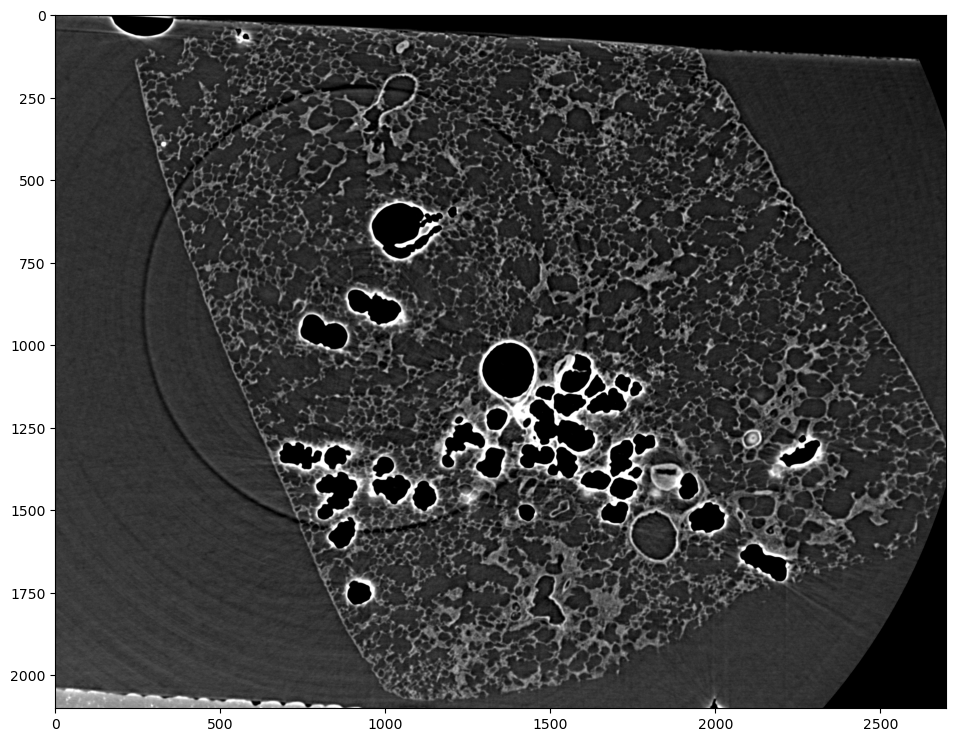

In [24]:
#Ploting the middle slice 
plt.figure(figsize=(16,9))
plt.imshow(roi_vol[850, :, :], cmap='gray')
plt.show()

In [25]:
roi_vol.shape

(1700, 2100, 2700)

In [26]:
# define the parameter for cliping the roi 

# size of 3D cube 
cube_size = 300
# step size in each direction
step_size = 200

In [27]:
# finding the range for the loop 
depth = roi_vol.shape[0]
# depth = 1200
row = roi_vol.shape[1]
col = roi_vol.shape[2]

In [28]:
print(list(range(0, depth, step_size)))
print(list(range(0, row-step_size, step_size)))
print(list(range(0, col-step_size, step_size)))

[0, 200, 400, 600, 800, 1000, 1200, 1400, 1600]
[0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800]
[0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400]


In [29]:
del vol 

In [30]:
# function to save slices of a volume into a defined folder 

def saveSlices(volume, folderName):
    depth = volume.shape[0]
    for aSlice in range(depth):
        img = volume[aSlice, :, :]
        if not os.path.exists(folderName):
            os.makedirs(folderName)
        fName = os.path.join(folderName, f'slice_{aSlice}.tif') 
        tifffile.imsave(fName, img)

In [31]:
save_dir = os.path.join('E:\\Data\\sam_data\\new', data_dir.split('\\')[1], 'slices')
print(save_dir)

E:\Data\sam_data\new\MD_1264_A6_1_Z3.3mm_corr_phrt\slices


In [32]:
minmax = {}
all_roi = []
mins = []
maxs = []

depthList = list(range(0, depth, step_size))

for d in tqdm(depthList[:-1]):
    for r in range(0, row-step_size, step_size):
        for c in range(0, col-step_size, step_size):
            cube = roi_vol[d:d+cube_size, r:r+cube_size, c:c+cube_size]
            
            roiName = f'{d}-{d+cube_size}x{rowStartingOffset+r}-{rowStartingOffset+r+cube_size}x{colStartingOffset+c}-{colStartingOffset+c+cube_size}'
            all_roi.append(roiName)
            mins.append(cube.min())
            maxs.append(cube.max())
            
            
            #fileName = f'{os.path.dirname(data_dir)}\\tiles\\{d}-{d+cube_size}x{rowStartingOffset+r}-{rowStartingOffset+r+cube_size}x{colStartingOffset+c}-{colStartingOffset+c+cube_size}.raw'
            #cube.tofile(fileName)
            
            pathName = f'{os.path.dirname(save_dir)}\\tiles\\{d}-{d+cube_size}x{rowStartingOffset+r}-{rowStartingOffset+r+cube_size}x{colStartingOffset+c}-{colStartingOffset+c+cube_size}'
            saveSlices(cube, pathName)

            

minList = []
for i in range(len(mins)):
    minList.append(mins[i].tolist())
    
maxList = []
for i in range(len(maxs)):
    maxList.append(maxs[i].tolist())
    

minmax = {}
minmax['roi'] = all_roi
minmax['min'] = minList
minmax['max'] = maxList
minmax['coordinate'] = ['depth', 'row', 'col']
minmax['rowstart'] = [rowStartingOffset]
minmax['rowend'] = [rowEndingOffset]
minmax['colstart'] = [colStartingOffset]
minmax['colend'] = [colEndingOffset]

import json
jsonString = json.dumps(minmax)
jsonFile = open(save_dir.split('slices')[0] + 'tiles.json', "w")
jsonFile.write(jsonString)
jsonFile.close()

  0%|          | 0/8 [00:00<?, ?it/s]